In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import talib

np.set_printoptions(suppress=True)

import sys, os
sys.path.append("../src")

from helpers import build_distance_matrix
from macro_models import batched_gaussian_process
from priors import diffusion_prior, length_scale_prior
from micro_models import dynamic_batch_diffusion, fast_dm_simulate, diffusion_trial
from networks_2 import DynamicGaussianNetwork
from context import generate_design_matrix
from transformations import unscale_z, scale_z

In [2]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

from tensorflow.keras.layers import GRU, Dense, LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical

from tqdm.notebook import tqdm
from functools import partial

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))


# physical_devices = tf.config.list_physical_devices('CPU')
# tf.config.set_visible_devices([], 'GPU')
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-11-03 16:49:34.054579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 16:49:34.078004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 16:49:34.078139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
T = 3200
N_PARAMS = 6
DIST_MAT = build_distance_matrix(T)
# AMPLITUDES = [0.20, 0.20, 0.20, 0.20, 0.20, 0.15]
AMPLITUDES = [0.15, 0.15, 0.15, 0.15, 0.1, 0.05]

BATCH_SIZE = 16
TEST_SIZE = 10
N_CHUNKS = 4000
EPOCHS = 100

2022-11-03 16:49:34.113524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 16:49:34.114058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 16:49:34.114229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 16:49:34.114354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [5]:
MACRO_MEAN = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
MACRO_STD = [2.8, 2.8, 2.8, 2.8, 2.8, 2.8]

MICRO_MEAN = [1.3, 1.3, 1.3, 1.3, 1.3, 0.3]
MICRO_STD = [1.0, 1.0, 1.0, 1.0, 0.75, 0.25]

In [6]:
EMPIRIC_COLOR = '#1F1F1F'
NEURAL_COLOR = '#852626'
COMPARISON_COLOR = '#133a76'

In [7]:
def generator_fun(batch_size):
    theta0 = diffusion_prior(batch_size, n_cond=N_PARAMS-2)
    eta = length_scale_prior(batch_size, N_PARAMS)
    theta_t = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
    context = generate_design_matrix(batch_size, T)

    rt = dynamic_batch_diffusion(theta_t, context)
    x = np.concatenate((rt, to_categorical(context[:, :, np.newaxis])), axis=-1)

    eta_z = scale_z(eta, MACRO_MEAN, MACRO_STD)
    theta_t_z = scale_z(theta_t, MICRO_MEAN, MICRO_STD)

    return eta_z.astype(np.float32), theta_t_z.astype(np.float32), x.astype(np.float32)

In [8]:
eta_z, theta_t_z, x = generator_fun(10)
print(eta_z.shape)
print(theta_t_z.shape)
print(x.shape)

(10, 6)
(10, 3200, 6)
(10, 3200, 5)


In [9]:
# f, axarr = plt.subplots(10, 6, figsize=(25, 30))
# time = np.arange(1, theta_t.shape[1]+1)
# for j in range(10):
#     for i in range(6):
#         ax = axarr[j, i]
#         ax.plot(time, theta_t[j, :, i], label='True', color='black', linestyle='dashed')
#         sns.despine(ax=ax)
#         ax.legend()
#         ax.grid(alpha=0.3)
# f.tight_layout()

In [10]:
def presimulate_data():
    for n in range(N_CHUNKS):
        if n > 261:
            eta_z, theta_t_z, x = generator_fun(BATCH_SIZE)
            np.save(f'../data/offline_data_new/data/x_{n}.npy', x)
            np.save(f'../data/offline_data_new/parameters/eta_params_{n}.npy', eta_z)
            np.save(f'../data/offline_data_new/parameters/theta_params_{n}.npy', theta_t_z)

In [11]:
# presimulate_data()

In [12]:
class ChunkLoader:
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.data_list = sorted(os.listdir(os.path.join(path_to_data, 'data')), key=lambda f: int(re.sub('\D', '', f)))
        self.eta_list = sorted(os.listdir(os.path.join(path_to_data, 'parameters/eta')), key=lambda f: int(re.sub('\D', '', f)))
        self.theta_list = sorted(os.listdir(os.path.join(path_to_data, 'parameters/theta')), key=lambda f: int(re.sub('\D', '', f)))
        self.indices = list(range(len(self.data_list)))
        np.random.shuffle(self.indices)
        self.num_batches = len(self.data_list)
        self.current_index = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current_index < self.num_batches:
            self.current_index += 1
            idx = self.indices[self.current_index -1]
            batch_x = np.load(os.path.join(self.path_to_data, 'data', self.data_list[idx]))
            batch_eta_params = np.load(os.path.join(self.path_to_data, 'parameters/eta', self.eta_list[idx]))
            batch_theta_params = np.load(os.path.join(self.path_to_data, 'parameters/theta', self.theta_list[idx]))
            return batch_eta_params, batch_theta_params, batch_x
        self.indices = list(range(len(self.data_list)))
        np.random.shuffle(self.indices)
        self.current_index = 0
        raise StopIteration

In [13]:
loader = ChunkLoader('../data/offline_data_new')

## Network

In [14]:
network_settings = {
    'embedding_gru_units': 256, #256
    'embedding_lstm_units' : 256, #256
    'dense_pre_args': dict(units=256, activation='selu', kernel_initializer='lecun_normal'), #256
    'dense_micro_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'), #128
    'dense_macro_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'), #128
    'macro_lstm_units': 128, #128
    'n_micro_params': 6,
    'n_macro_params': 6
}
network = DynamicGaussianNetwork(network_settings)

In [15]:
steps_per_epoch = 500
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2500,
    decay_rate=0.8,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [16]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

In [17]:
def epoch_trainer(generator, network, optimizer, steps_per_epoch, p_bar):
    losses = []
    for step, batch in enumerate(generator):
        with tf.GradientTape() as tape:
            
            # Simulate from model
            eta_z, theta_t_z, data = batch

            idx = np.random.choice(np.arange(0, 16), size=8, replace=False, p=None)

            # Forward pass
            eta_z_hat, theta_t_z_hat = network(data[idx], eta_z[idx])

            # loss computation
            loss_eta = nll(eta_z[idx], eta_z_hat)
            loss_theta = nll(theta_t_z[idx], theta_t_z_hat)
            total_loss = loss_eta + loss_theta
        
        # One step backprop
        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss.Macro: {:.3f},Loss.Micro: {:.3f},Loss.Avg: {:.3f}"
                              .format(ep, step, loss_eta.numpy(), loss_theta.numpy(), np.mean(losses)))
        p_bar.update(1)
    return losses

In [ ]:
losses = []
for ep in range(1, EPOCHS+1):
    with tqdm(total=loader.num_batches, desc=f'Training Epoch {ep}') as p_bar:
        loss_ep = epoch_trainer(loader, network, optimizer, steps_per_epoch, p_bar)
        losses.append(loss_ep)
    network.save_weights('../trained_networks/gp_ddm_3200_joint_offline_factorized_new')

Training Epoch 1:   0%|          | 0/4000 [00:00<?, ?it/s]

## Validation

In [ ]:
network.load_weights('../trained_networks/gp_ddm_3200_joint_offline_factorized_new')

In [20]:
eta_z_test, theta_t_z_test, x_test = generator_fun(TEST_SIZE)

In [21]:
eta_z_pred, theta_t_z_pred = network.sample_n(x_test, 100)

In [22]:
eta_test = unscale_z(eta_z_test, MACRO_MEAN, MACRO_STD)
theta_t_test = unscale_z(theta_t_z_test, MICRO_MEAN, MICRO_STD)

eta_pred = unscale_z(eta_z_pred, MACRO_MEAN, MACRO_STD)
theta_t_pred = unscale_z(theta_t_z_pred, MICRO_MEAN, MICRO_STD)

In [23]:
theta_t_pred.shape

TensorShape([100, 10, 3200, 6])

In [24]:
theta_t_pred_mean = theta_t_pred.numpy().mean(axis=0)
theta_t_pred_std = theta_t_pred.numpy().std(axis=0)

##  Visualize Predictions Over Time

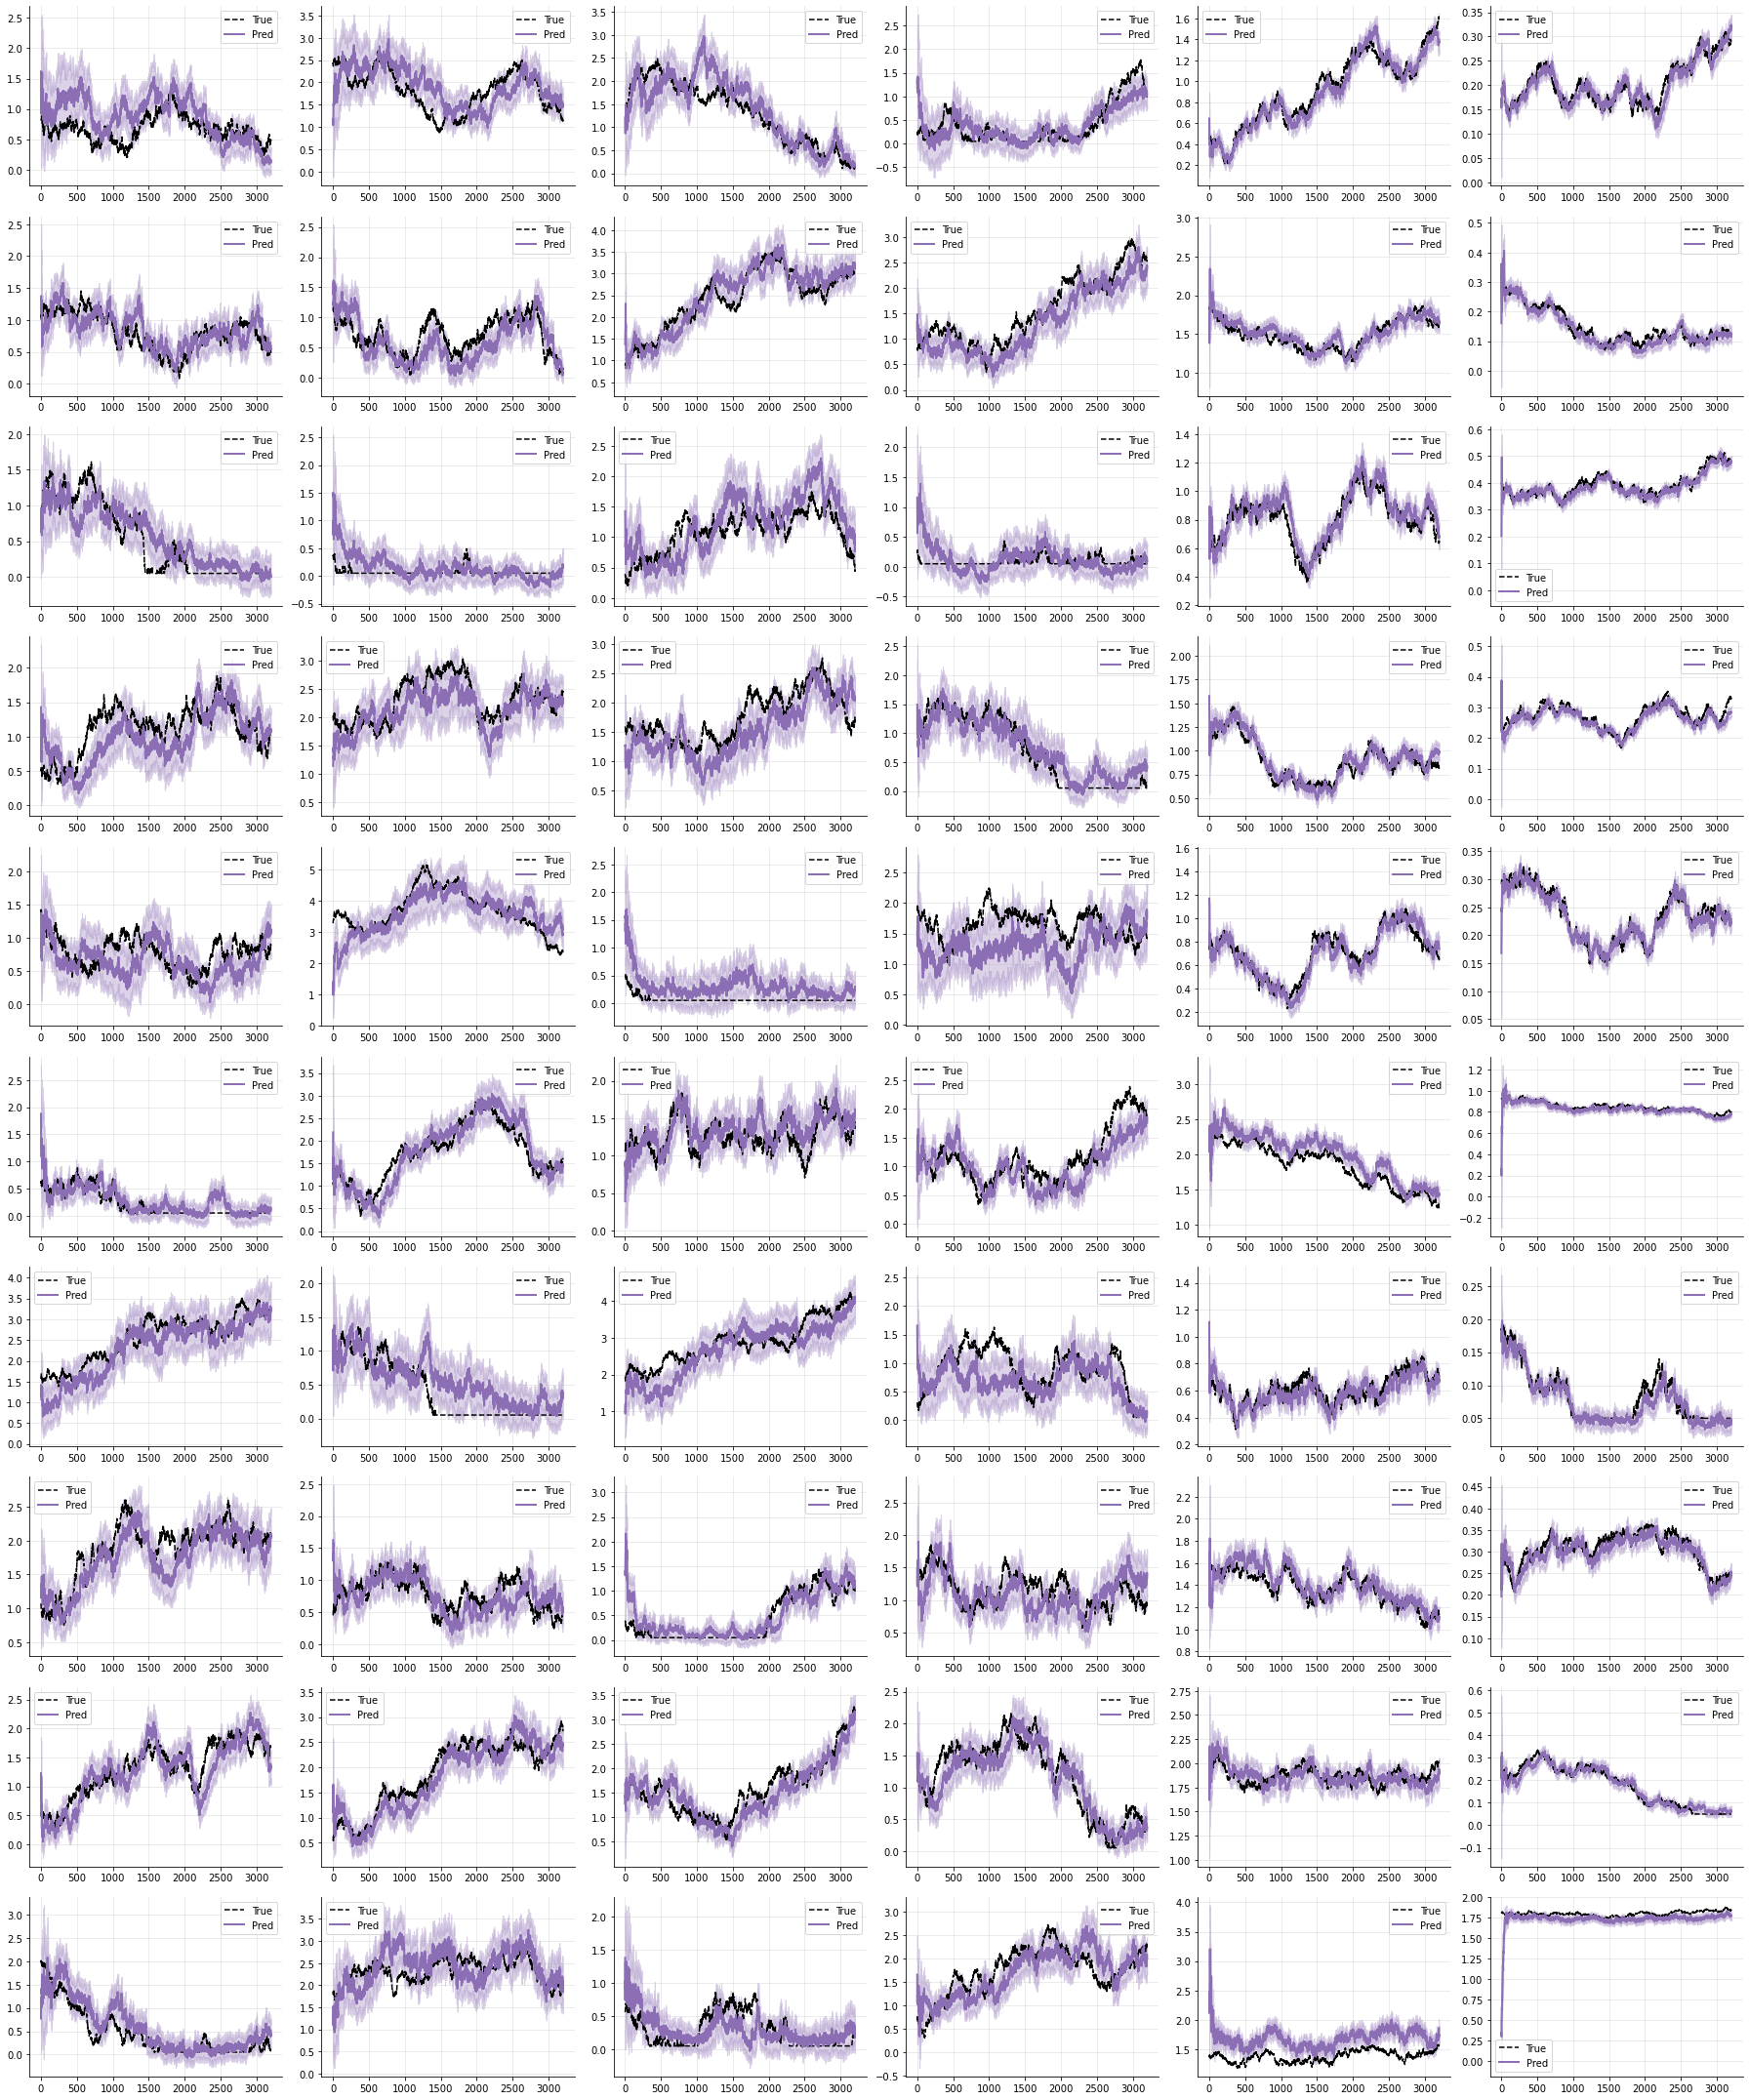

In [25]:
f, axarr = plt.subplots(TEST_SIZE, 6, figsize=(25, 30))
std_mul = 1
time = np.arange(1, theta_t_test.shape[1]+1)
for j in range(TEST_SIZE):
    for i in range(6):
        ax = axarr[j, i]
        ax.plot(time, theta_t_test[j, :, i], label='True', color='black', linestyle='dashed')
        ax.plot(time, theta_t_pred_mean[j, :, i], label='Pred', lw=2, color='#8c6eb5')
        ax.fill_between(time, 
                        theta_t_pred_mean[j, :, i] + std_mul * theta_t_pred_std[j, :, i], 
                        theta_t_pred_mean[j, :, i] - std_mul * theta_t_pred_std[j, :, i], color='#8c6eb5', alpha=0.3)
        sns.despine(ax=ax)
        ax.legend()
        ax.grid(alpha=0.3)
f.tight_layout()